In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt

loader = set_notebook_env.set_env(data_dir="../data/")
    

In [2]:
num, tags, qual = loader.load_raw()

In [3]:
num.shape, tags.shape, qual.shape

((89892, 8), (89892, 20), (89892, 3))

In [4]:
df = pd.concat([num, tags, qual], axis=1)
df.head()


,5,1.5,2,0,NaN,0.1,0.2,1,0,0.1,...,0.12,0.13,0.14,0.15,0.16,0.17,1.1,Criminal Justice,George Mason University,VA
0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,3.2,3.0,4.0,0.0,NaN,0.0,1,0,2,1,...,0,0,0,0,0,0,0,English,Alabama State University,AL
2,3.6,3.5,10.0,1.0,NaN,0.0,0,0,6,3,...,0,0,0,0,0,1,0,English,University of Kentucky,KY
3,1.0,5.0,1.0,0.0,NaN,0.0,0,0,0,0,...,0,0,0,0,0,0,0,English,Keiser University,FL
4,3.5,3.3,22.0,0.0,56.0,7.0,1,0,8,13,...,0,0,0,3,0,1,3,English,Eastern Florida State College,FL


In [5]:
num_cols = [
    "avg_rating", "avg_difficulty", "num_ratings", "pepper",
    "would_take_again_prop", "num_online_ratings",
    "male", "female"
]

tag_cols = [
    "tough_grader", "good_feedback", "respected", "lots_to_read",
    "participation_matters", "no_skip", "lots_of_hw", "inspirational",
    "pop_quizzes", "accessible", "papers", "clear_grading",
    "hilarious", "test_heavy", "few_things", "amazing_lectures",
    "caring", "extra_credit", "group_projects", "lecture_heavy"
]

qual_cols = ["major", "university", "state"]

df.columns = num_cols + tag_cols + qual_cols


In [6]:
df.isna().sum().sort_values(ascending=False)


would_take_again_prop    77732
avg_rating               19889
avg_difficulty           19889
university               19889
major                    19889
state                    19889
num_ratings              19889
pepper                   19889
num_online_ratings       19889
male                         0
clear_grading                0
lecture_heavy                0
group_projects               0
extra_credit                 0
caring                       0
amazing_lectures             0
few_things                   0
test_heavy                   0
hilarious                    0
papers                       0
female                       0
accessible                   0
pop_quizzes                  0
lots_of_hw                   0
no_skip                      0
participation_matters        0
lots_to_read                 0
respected                    0
good_feedback                0
tough_grader                 0
inspirational                0
dtype: int64

In [7]:
(df["male"] & df["female"]).sum()


np.int64(2213)

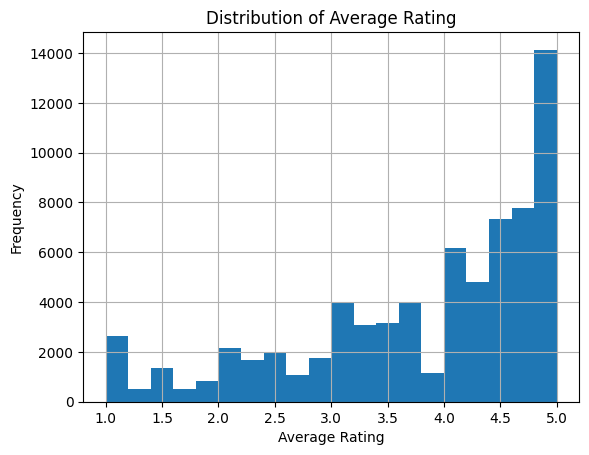

In [8]:
df["avg_rating"].hist(bins=20)
plt.title("Distribution of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

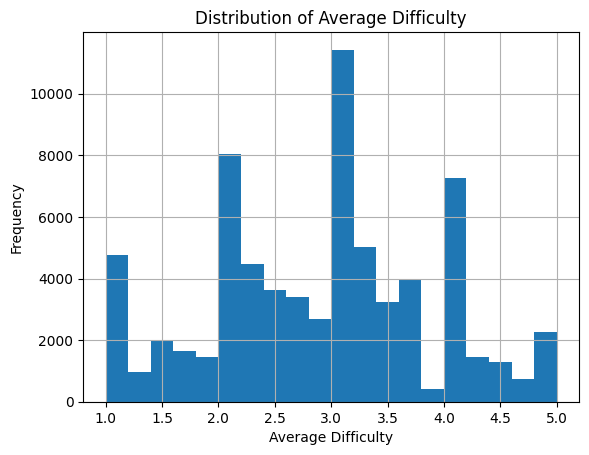

In [9]:
df["avg_difficulty"].hist(bins=20)
plt.title("Distribution of Average Difficulty")
plt.xlabel("Average Difficulty")
plt.ylabel("Frequency")
plt.show()

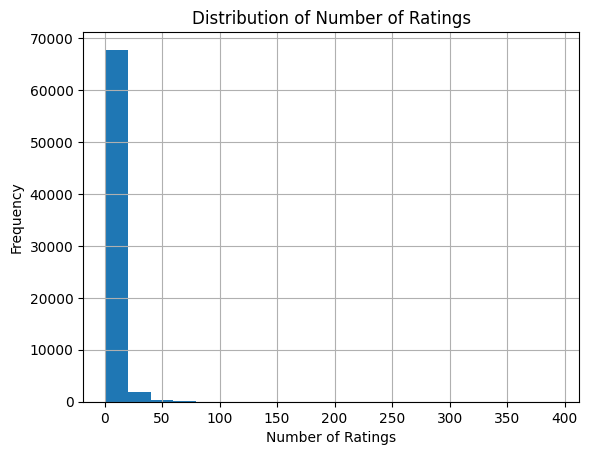

In [10]:
df["num_ratings"].hist(bins=20)
plt.title("Distribution of Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()